# Sentiment Analysis

Sentiment analysis is the process of analyzing digital text to determine if the emotional tone of the message is positive, negative, or neutral. It’s often used by businesses to detect sentiment in social data, gauge brand reputation, and understand customers.

Sentiment analysis faces a major hurdle due to the complex nature of human language. Textual data frequently incorporate sarcasm, irony, and other types of figurative language that can be hard to decipher using a conventional approach


In this tutorial, we will try to learn how we can use Stanza and NLTK to do the Sentiment Analysis

## Installations

In [ ]:
%%capture
!pip install stanza datasets nltk matplotlib tqdm wordcloud scikit-learn 

At the time of development, Stanza's version is 1.5.0 and Nltk's version is 3.8.1


## Setting Parameters

In [ ]:
use_gpu = True
shrink_dataset = False

## Imports

In [ ]:
import stanza
import nltk
import matplotlib.pyplot as plt
from datasets import load_dataset
from nltk.corpus import stopwords
from collections import Counter
from tqdm.auto import tqdm
from collections import defaultdict
from sklearn.metrics import classification_report
from wordcloud import WordCloud


## Downloads

In [ ]:
%%capture
stanza.download('en',logging_level='WARN') # download English model
nltk.download('stopwords',quiet=True)

## Dataset
We will use [Amazon US review dataset](https://huggingface.co/datasets/amazon_us_reviews) of 
hugging face.

As this dataset is huge, we will be using data of a subcategory i.e. Personal_Care_Appliances_v1_00

It has about 85981 reviews. 


In [ ]:
%%capture
dataset = load_dataset('amazon_us_reviews','Personal_Care_Appliances_v1_00') 

Let's take a look at one sample record 

In [ ]:
dataset['train'][0]

{'marketplace': 'US',
 'customer_id': '32114233',
 'review_id': 'R1QX6706ZWJ1P5',
 'product_id': 'B00OYRW4UE',
 'product_parent': '223980852',
 'product_title': 'Elite Sportz Exercise Sliders are Double Sided and Work Smoothly on Any Surface. Wide Variety of Low Impact Exercise’s You Can Do. Full Body Workout, Compact for Travel or Home Ab Workout',
 'product_category': 'Personal_Care_Appliances',
 'star_rating': 5,
 'helpful_votes': 0,
 'total_votes': 0,
 'vine': 0,
 'verified_purchase': 1,
 'review_headline': 'Good quality. Shipped',
 'review_body': 'Exactly as described. Good quality. Shipped fast',
 'review_date': '2015-08-31'}

In [ ]:
dataset['train'].shape

(85981, 15)

Shrink dataset if set for faster execution

In [ ]:
size = dataset['train'].shape[0]
if shrink_dataset:
  size  = 100

let's get the required data and label. We will use the review_body and star_rating to classify the sentiment.


## Data Analysis

In [ ]:
def plot_pie(ratings,name):
  plt.pie(ratings.values(), labels=ratings.keys(), autopct='%1.1f%%')
  plt.title(f"Distribution of Star Ratings - {name}")
  plt.show()

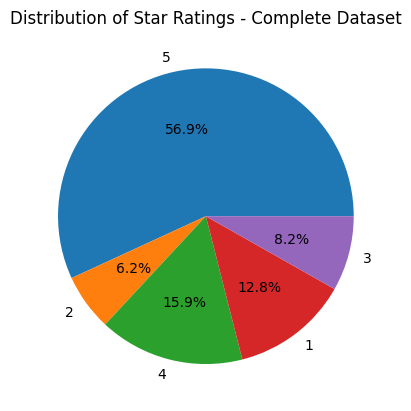

Counter({5: 48897, 2: 5341, 4: 13657, 1: 11036, 3: 7050})

In [ ]:
ratings = Counter(dataset['train']['star_rating'])
plot_pie(ratings, 'Complete Dataset')
ratings

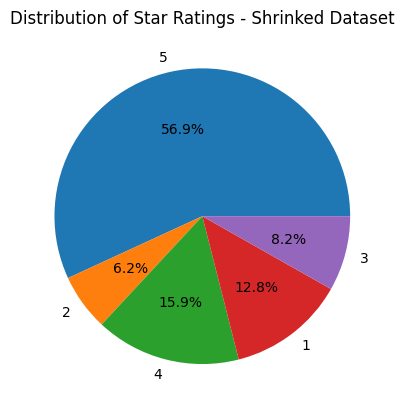

Counter({5: 48897, 2: 5341, 4: 13657, 1: 11036, 3: 7050})

In [ ]:
ratings = Counter(dataset['train']['star_rating'][0:size])
plot_pie(ratings, 'Shrinked Dataset')
ratings

Most of the ratings are 5, so we can expect more positive sentiments.

## Common Preprocessing

 `map_dataset` function takes the dataset and maps each rating to a sentiment value of 0, 1, or 2, representing negative, neutral, and positive sentiment, respectively. By default, all the ratings are included, but we can include specific ratings as well by using `raings_included` parameter. The output is a list of pre-processed sentiment values and corresponding review bodies that can be used for further analysis or modeling.

In [ ]:
def map_dataset(dataset_df, raings_included={1,2,3,4,5}):
  sentiments  = []
  review_texts = []
  for index, row in dataset_df.iterrows():
    rating = row['star_rating']
    sentiment = None
    if rating in raings_included:
      if rating <=2:
        sentiment = 0
      elif rating >=4:
        sentiment = 2
      else:
        sentiment = 1
      sentiments.append(sentiment)
      review_texts.append(row['review_body'])
  return sentiments, review_texts

Let's get all the labels and review texts. We will create **two types of datasets**, one with all the ratings (1,2,3,4,5) i.e. `true_labels_all` and `review_texts_all` and another with just star ratings of 1 (lowest) and 5(highest) i.e. `true_labels_filtered` and `review_texts_filtered`. We can think of 1-star ratings as gold-label examples of negative sentiment, and 5-star ratings as gold-label examples of positive sentiment. Better performance is expected from the filtered dataset.

In [ ]:
df = dataset['train'].to_pandas().iloc[:size]
true_labels_all,review_texts_all = map_dataset(df)
true_labels_filtered, review_texts_filtered = map_dataset(df,{1,5})

## Preprocessing Using Stanza

 `pre_process_review_texts` function takes a list of texts as input and applies pre-processing steps such as lowercasing, tokenization, lemmatization, and stop word(from nltk corpus) removal using the Stanza library. The output is a list of pre-processed text data that can be used for further analysis or modeling.

In [ ]:
def pre_process_review_texts(nlp,texts):
  processed_texts = []
  for text in tqdm(texts):
    doc = nlp(text.lower())
    lemmatized_tokens= []
    for sentence in doc.sentences:
        for word in sentence.words:
          if word.lemma and word.lemma not in stopwords.words('english'):
            lemmatized_tokens.append(word.lemma)
    processed_text = ' '.join(lemmatized_tokens)
    processed_texts.append(processed_text)
  return processed_texts

The below code sets up a Stanza pipeline.
Here's what each of the parameters used in the Pipeline constructor means:

- lang='en': specifies that the language of the text data to be processed is English.
- processors='tokenize,lemma': specifies that two processing steps should be applied to the text data: tokenization (i.e., splitting the text into individual words or tokens) and lemmatization (i.e., reducing each word to its base form or lemma).
- logging_level='WARN': sets the logging level to "warning", which means that only warnings and errors will be logged during processing. This can be helpful for reducing the amount of output generated during processing.
- use_gpu: specifies whether to use the GPU (graphics processing unit) for processing


In [ ]:
%%capture
nlp = stanza.Pipeline(lang='en', processors='tokenize,lemma',logging_level='WARN',use_gpu=use_gpu)

**Preprocessed texts for both types of datasets**

In [ ]:
processed_texts_all = pre_process_review_texts(nlp,review_texts_all)

  0%|          | 0/85981 [00:00<?, ?it/s]

In [ ]:
processed_texts_filtered = pre_process_review_texts(nlp,review_texts_filtered)

  0%|          | 0/59933 [00:00<?, ?it/s]

Let's take a quick look at the word cloud of our processed texts of the complete dataset (Star ratings - 1 to 5)

In [ ]:
def show_word_cloud(processed_texts, custom_stop_words= ['br']):
  word_cloud_stop_words = set(stopwords.words('english'))
  word_cloud_stop_words.update(custom_stop_words) 
  all_reviews = " ".join(review for review in processed_texts)
  wordcloud = WordCloud(stopwords=word_cloud_stop_words).generate(all_reviews)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()


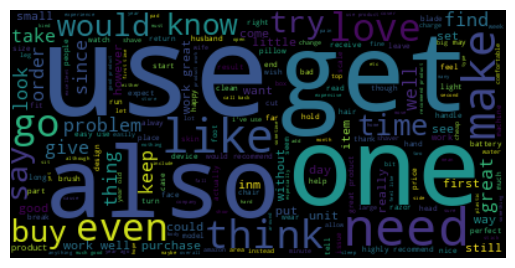

In [ ]:
show_word_cloud(processed_texts_all)

Now, let's take a quick look at the word cloud of our processed texts of the filtered dataset (Star ratings - 1 and 5 only)

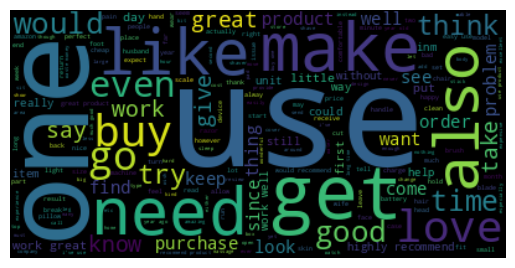

In [ ]:
show_word_cloud(processed_texts_filtered)

## Sentiment Analysis Using Stanza

`get_sentiment` function performs sentiment analysis on a given review (multiple sentences) using a Stanza pipeline object, and returns the sentiment with the highest frequency in the review. For e.g. if in a review, more sentences belong to the 0 class (Negative Sentiment) then we will consider that a negative  review

In [ ]:
def get_sentiment(stanza_sentiment_analyzer,text):
  sentiments = defaultdict(int)
  doc = stanza_sentiment_analyzer(text)
  total =0
  for sentence in doc.sentences:
    sentiments[sentence.sentiment]+=1
    total+=1
  all_values = dict([ (sentiment,sentiments[sentiment]/total) for sentiment in sentiments])
  sorted_values = sorted(all_values.items(), key=lambda x:x[1],reverse=True)
  return sorted_values[0][0]

`get_sentiments_using_stanza` function applies sentiment analysis using a Stanza pipeline object to a list of reviews and generates predicted labels.It also collects the true labels for these reviews. The output is a tuple containing two lists: predicted_sentiments and true_sentiments, which can be used for evaluating the performance of the sentiment analysis model.

In [ ]:
def get_sentiments_using_stanza(stanza_sentiment_analyzer,texts,labels):
  predicted_sentiments =[]
  true_sentiments = []
  for idx,text in tqdm(enumerate(texts),total=len(texts)):
    try:
      sentiment = get_sentiment(stanza_sentiment_analyzer,text)
      predicted_sentiments.append(sentiment)
      true_sentiments.append(labels[idx])
    except IndexError:
       pass
  return predicted_sentiments,true_sentiments

In [ ]:
%%capture
stanza_sentiment_analyzer = stanza.Pipeline(lang='en', processors='tokenize,sentiment',logging_level='WARN',use_gpu=use_gpu)

In [ ]:
predicted_sentiments_all_stanza,true_sentiments_all = get_sentiments_using_stanza(stanza_sentiment_analyzer, processed_texts_all,true_labels_all)

  0%|          | 0/85981 [00:00<?, ?it/s]

In [ ]:
predicted_sentiments_filtered_stanza,true_sentiments_filtered = get_sentiments_using_stanza(stanza_sentiment_analyzer, processed_texts_filtered,true_labels_filtered)

  0%|          | 0/59933 [00:00<?, ?it/s]

## Results Of Stanza Sentiment Analysis

**Result of the complete dataset analysis**

In [ ]:
print(classification_report(true_sentiments_all, predicted_sentiments_all_stanza,zero_division=0))

              precision    recall  f1-score   support

           0       0.42      0.39      0.41     16376
           1       0.10      0.56      0.17      7047
           2       0.91      0.46      0.61     62551

    accuracy                           0.46     85974
   macro avg       0.48      0.47      0.40     85974
weighted avg       0.75      0.46      0.54     85974



**Result of the filtered dataset analysis**

In [ ]:
print(classification_report(true_sentiments_filtered, predicted_sentiments_filtered_stanza,zero_division=0))

              precision    recall  f1-score   support

           0       0.47      0.42      0.45     11036
           1       0.00      0.00      0.00         0
           2       0.97      0.49      0.65     48896

    accuracy                           0.48     59932
   macro avg       0.48      0.30      0.37     59932
weighted avg       0.87      0.48      0.61     59932



## NLTK provides a sentiment analyzer too, let's try that one as well

## Imports

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

## Downloads

In [ ]:
%%capture
nltk.download('punkt',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('vader_lexicon',quiet=True)

## Preprocessing Using NLTK

 `pre_process_review_texts` function takes a list of texts as input and applies pre-processing steps such as lowercasing, tokenization, lemmatization, and stop word(from nltk corpus) removal using the **NLTK** library. The output is a list of pre-processed text data that can be used for further analysis or modeling.

In [ ]:
def preprocess_review_texts_using_nltk(texts):
  processed_texts = []
  for text in tqdm(texts):
      tokens = word_tokenize(text.lower())
      filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]
      lemmatizer = WordNetLemmatizer()
      lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
      processed_text = ' '.join(lemmatized_tokens)
      processed_texts.append(processed_text)
  return processed_texts


**Preprocessed texts for both types of datasets**

In [ ]:
processed_texts_all_nltk = preprocess_review_texts_using_nltk(review_texts_all)

  0%|          | 0/85981 [00:00<?, ?it/s]

In [ ]:
processed_texts_filtered_nltk = preprocess_review_texts_using_nltk(review_texts_filtered)

  0%|          | 0/59933 [00:00<?, ?it/s]

Let's take a quick look at the word cloud of our processed texts of the complete dataset (Star ratings - 1 to 5)

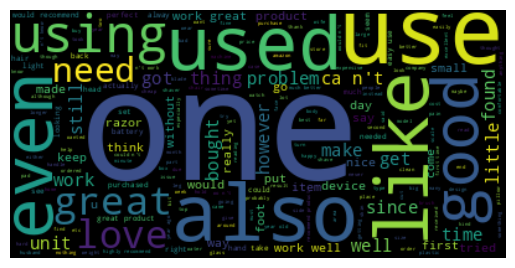

In [ ]:
show_word_cloud(processed_texts_all_nltk)

Now, let's take a quick look at the word cloud of our processed texts of the filtered dataset (Star ratings - 1 and 5 only)

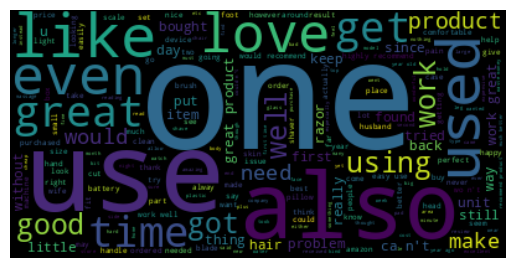

In [ ]:
show_word_cloud(processed_texts_filtered_nltk)

## Sentiment Analysis Using NLTK

`get_sentiment_using_nltk` function applies sentiment analysis using a SentimentIntensityAnalyzer to a list of reviews and generates predicted labels.It also collects the true labels for these reviews. The output is a tuple containing two lists: predicted_sentiments and true_sentiments, which can be used for evaluating the performance of the sentiment analysis model.`

In [ ]:
def get_sentiment_using_nltk(analyzer,texts,labels):
  predicted_sentiments =[]
  true_sentiments = []
  for idx,text in tqdm(enumerate(texts),total=len(texts)):
    try:
      scores = analyzer.polarity_scores(text)
      sentiment_score = scores['compound']
      predicted_sentiments.append(round(sentiment_score+1))
      true_sentiments.append(labels[idx])
    except IndexError:
       pass
  return predicted_sentiments,true_sentiments


In [ ]:
analyzer = SentimentIntensityAnalyzer()


In [ ]:
predicted_sentiments_all_nltk,true_sentiments_all = get_sentiment_using_nltk(analyzer, processed_texts_all_nltk,true_labels_all)

  0%|          | 0/85981 [00:00<?, ?it/s]

In [ ]:
predicted_sentiments_filtered_nltk,true_sentiments_filtered = get_sentiment_using_nltk(analyzer, processed_texts_filtered_nltk,true_labels_filtered)

  0%|          | 0/59933 [00:00<?, ?it/s]

## Results Of NLTK Sentiment Analysis

**Result of the complete dataset analysis**

In [ ]:
print(classification_report(true_sentiments_all, predicted_sentiments_all_nltk,zero_division=0))

              precision    recall  f1-score   support

           0       0.58      0.19      0.29     16377
           1       0.12      0.43      0.18      7050
           2       0.84      0.74      0.79     62554

    accuracy                           0.61     85981
   macro avg       0.51      0.45      0.42     85981
weighted avg       0.73      0.61      0.64     85981



**Result of the filtered dataset analysis**

In [ ]:
print(classification_report(true_sentiments_filtered, predicted_sentiments_filtered_nltk,zero_division=0))

              precision    recall  f1-score   support

           0       0.65      0.22      0.33     11036
           1       0.00      0.00      0.00         0
           2       0.93      0.76      0.83     48897

    accuracy                           0.66     59933
   macro avg       0.53      0.33      0.39     59933
weighted avg       0.88      0.66      0.74     59933



## Conclusion
Both of the sentiment analyzers did not give great performance for our use case. Reasons could be the complexity and ambiguity of natural language or due to the inexact mapping of star ratings and sentiment. Sentiment analysis could be affected by several factors such as sarcasm, irony, and cultural nuances that are difficult to detect using automated tools. As a result, it is challenging to achieve high accuracy in sentiment analysis. Maybe we can improve preprocessing to achieve better performance. Filtered datasets that had extreme positive(Star - 5) and extreme negative (Star -1) performed little better than the complete dataset. 
Different libraries may have different strengths and weaknesses, and it is important to choose the most appropriate tool based on the specific requirements and constraints of the project. In summary, while both NLTK and Stanza can be useful tools for quick sentiment analysis, the complexity, and ambiguity of natural language, as well as limited preprocessing of text data, can pose significant challenges, resulting in relatively low performance.

Finally, let's move to the next [page](https://pal0064.github.io/nlp_tutorials/stanza/index.html#LearnMore)